Projekt Uczenia Maszynowego - Predykcja Opóźnień Lotów
Semestr letni 2024/25
Skład grupy i podział zadań

Kamil Arkit, Dawid Chomiak: Znalezienie i przygotowanie danych
Kamil Arkit, Dominik Sobótka: Trenowanie, testowanie i ocena modelu 1
Dawid Chomiak, Łukasz Guziczak: Trenowanie, testowanie i ocena modelu 2
Wszyscy: Sprawozdanie i wnioski

1. Opis danych i motywacja autorów
Zbiór danych
Wykorzystaliśmy zbiór danych "Flight Delays and Cancellations" z platformy Kaggle (US Department of Transportation), zawierający szczegółowe informacje o lotach w USA za 2015 rok. Dataset składa się z ponad 5.8 miliona rekordów lotów z 31 atrybutami.
Źródło: https://www.kaggle.com/datasets/usdot/flight-delays
Motywacja
Wybór tego problemu był motywowany:

Praktycznym zastosowaniem w branży lotniczej dla optymalizacji operacji
Znaczeniem ekonomicznym - opóźnienia kosztują branże miliardy dolarów rocznie
Korzyściami dla pasażerów - lepsze planowanie podróży
Bogatym zbiorem danych umożliwiającym zastosowanie różnych technik ML
Aktualnością problemu - opóźnienia lotów dotykają miliony podróżnych

Główne pliki danych:

flights.csv - dane o lotach (~5.8M rekordów)
airlines.csv - informacje o liniach lotniczych
airports.csv - dane o lotniskach

Kluczowe atrybuty (flights.csv):

YEAR, MONTH, DAY - data lotu
DAY_OF_WEEK - dzień tygodnia
AIRLINE - kod linii lotniczej
FLIGHT_NUMBER - numer lotu
ORIGIN_AIRPORT, DESTINATION_AIRPORT - lotniska wylotu i przylotu
SCHEDULED_DEPARTURE, DEPARTURE_TIME - planowany i rzeczywisty czas wylotu
DEPARTURE_DELAY - opóźnienie wylotu (w minutach)
SCHEDULED_ARRIVAL, ARRIVAL_TIME - planowany i rzeczywisty czas przylotu
ARRIVAL_DELAY - opóźnienie przylotu (w minutach)
CANCELLED - czy lot został odwołany
DISTANCE - dystans lotu
AIR_TIME - czas lotu w powietrzu

Zmienna docelowa:

DEPARTURE_DELAY przekształcone na klasyfikację binarną: opóźnienie >15 minut = 1, inaczej = 0

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("usdot/flight-delays")

print("Path to dataset files:", path)

100%|██████████| 191M/191M [01:46<00:00, 1.89MB/s] 

Extracting files...


Path to dataset files: C:\Users\kamil\.cache\kagglehub\datasets\usdot\flight-delays\versions\1


In [8]:
import os
import platform

def get_dataset_path():
    system = platform.system()
    username = os.getenv('USERNAME') or os.getenv('USER')
    
    if system == "Windows":
        return rf'C:\Users\{username}\.cache\kagglehub\datasets\usdot\flight-delays\versions\1'
    else:  # Linux/Mac
        return f'/home/{username}/.cache/kagglehub/datasets/usdot/flight-delays/versions/1'

DATASET_PATH = get_dataset_path()

Wczytanie danych i analiza eksploracyjna

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Wczytanie danych
print("Wczytywanie danych...")
flights = pd.read_csv(os.path.join(DATASET_PATH, 'flights.csv'))
airlines = pd.read_csv(os.path.join(DATASET_PATH, 'airlines.csv'))
airports = pd.read_csv(os.path.join(DATASET_PATH, 'airports.csv'))

print("Kształt danych flights:", flights.shape)
print("Kształt danych airlines:", airlines.shape)
print("Kształt danych airports:", airports.shape)

# Podstawowe informacje
print("\nPierwsze 5 wierszy flights:")
print(flights.head())

print("\nInformacje o danych:")
print(flights.info())

print("\nBraki danych:")
missing_data = flights.isnull().sum()
print(missing_data[missing_data > 0].sort_values(ascending=False))

Wczytywanie danych...
Kształt danych flights: (5819079, 31)
Kształt danych airlines: (14, 2)
Kształt danych airports: (322, 7)

Pierwsze 5 wierszy flights:
   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS   
1  2015      1    1            4      AA           2336      N3KUAA   
2  2015      1    1            4      US            840      N171US   
3  2015      1    1            4      AA            258      N3HYAA   
4  2015      1    1            4      AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  ...  ARRIVAL_TIME  \
0            ANC                 SEA                    5  ...         408.0   
1            LAX                 PBI                   10  ...         741.0   
2            SFO                 CLT                   20  ...         811.0   
3            LAX                 MIA                   20  ...         756.0   
4            SEA 

Statystyki opóźnień wylotu:
count    5.732926e+06
mean     9.370158e+00
std      3.708094e+01
min     -8.200000e+01
25%     -5.000000e+00
50%     -2.000000e+00
75%      7.000000e+00
max      1.988000e+03
Name: DEPARTURE_DELAY, dtype: float64


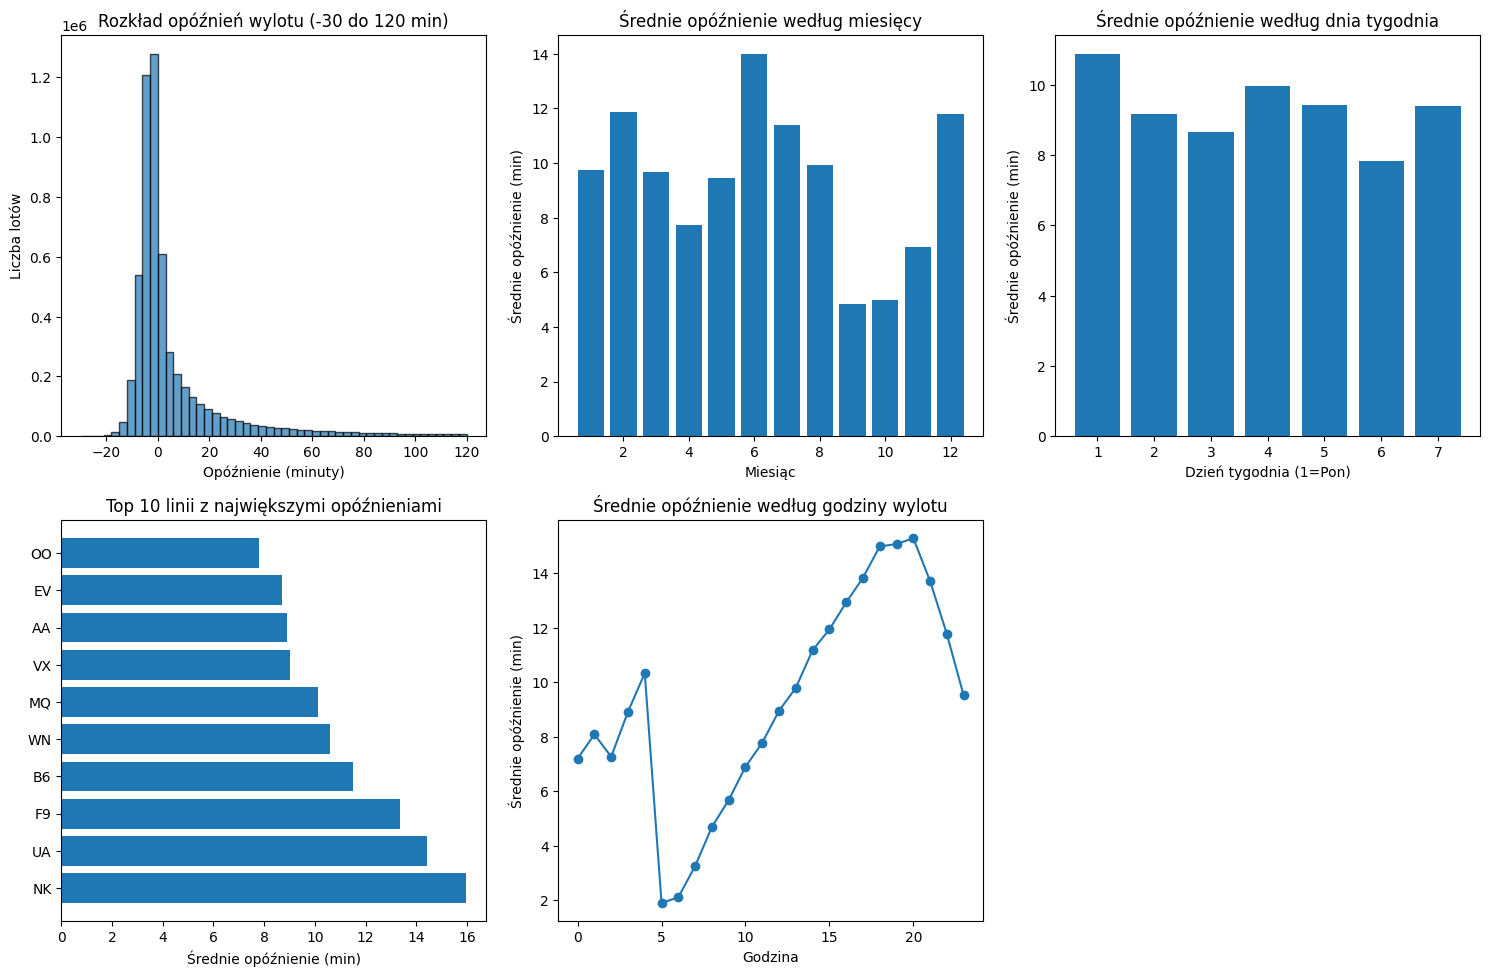


Procent odwołanych lotów: 1.54%


In [12]:
# Analiza opóźnień wylotu
print("Statystyki opóźnień wylotu:")
delay_stats = flights['DEPARTURE_DELAY'].describe()
print(delay_stats)

# Wizualizacja rozkładu opóźnień
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
# Ograniczenie do wartości rozsądnych dla wizualizacji
delays_filtered = flights['DEPARTURE_DELAY'].dropna()
delays_filtered = delays_filtered[(delays_filtered >= -30) & (delays_filtered <= 120)]
plt.hist(delays_filtered, bins=50, edgecolor='black', alpha=0.7)
plt.title('Rozkład opóźnień wylotu (-30 do 120 min)')
plt.xlabel('Opóźnienie (minuty)')
plt.ylabel('Liczba lotów')

plt.subplot(2, 3, 2)
# Opóźnienia według miesięcy
monthly_delays = flights.groupby('MONTH')['DEPARTURE_DELAY'].mean()
plt.bar(monthly_delays.index, monthly_delays.values)
plt.title('Średnie opóźnienie według miesięcy')
plt.xlabel('Miesiąc')
plt.ylabel('Średnie opóźnienie (min)')

plt.subplot(2, 3, 3)
# Opóźnienia według dnia tygodnia
weekly_delays = flights.groupby('DAY_OF_WEEK')['DEPARTURE_DELAY'].mean()
plt.bar(weekly_delays.index, weekly_delays.values)
plt.title('Średnie opóźnienie według dnia tygodnia')
plt.xlabel('Dzień tygodnia (1=Pon)')
plt.ylabel('Średnie opóźnienie (min)')

plt.subplot(2, 3, 4)
# Top 10 linii lotniczych z największymi opóźnieniami
airline_delays = flights.groupby('AIRLINE')['DEPARTURE_DELAY'].mean().nlargest(10)
plt.barh(airline_delays.index, airline_delays.values)
plt.title('Top 10 linii z największymi opóźnieniami')
plt.xlabel('Średnie opóźnienie (min)')

plt.subplot(2, 3, 5)
# Opóźnienia według godziny
flights['SCHEDULED_HOUR'] = flights['SCHEDULED_DEPARTURE'].astype(str).str.zfill(4).str[:2].astype(int)
hourly_delays = flights.groupby('SCHEDULED_HOUR')['DEPARTURE_DELAY'].mean()
plt.plot(hourly_delays.index, hourly_delays.values, marker='o')
plt.title('Średnie opóźnienie według godziny wylotu')
plt.xlabel('Godzina')
plt.ylabel('Średnie opóźnienie (min)')

plt.tight_layout()
plt.show()

# Analiza odwołanych lotów
cancelled_rate = flights['CANCELLED'].mean() * 100
print(f"\nProcent odwołanych lotów: {cancelled_rate:.2f}%")

In [13]:
# Filtrowanie danych - usunięcie odwołanych lotów i outlierów
print("Przygotowanie danych...")
df_model = flights.copy()

# Usunięcie odwołanych lotów
df_model = df_model[df_model['CANCELLED'] == 0]
print(f"Pozostało {len(df_model)} lotów po usunięciu odwołanych")

# Usunięcie wierszy z brakami w kluczowych kolumnach
key_columns = ['DEPARTURE_DELAY', 'AIRLINE', 'ORIGIN_AIRPORT', 
               'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DISTANCE']
df_model = df_model.dropna(subset=key_columns)
print(f"Pozostało {len(df_model)} lotów po usunięciu braków")

# Filtrowanie ekstremalnych wartości opóźnień
df_model = df_model[(df_model['DEPARTURE_DELAY'] >= -30) & 
                   (df_model['DEPARTURE_DELAY'] <= 300)]
print(f"Pozostało {len(df_model)} lotów po filtrowaniu outlierów")

# Próbkowanie danych dla efektywności (opcjonalne dla dużych zbiorów)
if len(df_model) > 500000:
    df_model = df_model.sample(n=500000, random_state=42)
    print(f"Próbkowanie do {len(df_model)} rekordów")

Przygotowanie danych...
Pozostało 5729195 lotów po usunięciu odwołanych
Pozostało 5729195 lotów po usunięciu braków
Pozostało 5717775 lotów po filtrowaniu outlierów
Próbkowanie do 500000 rekordów


In [14]:
# Tworzenie zmiennej docelowej - opóźnienie >15 minut
df_model['DELAYED'] = (df_model['DEPARTURE_DELAY'] > 15).astype(int)
delay_rate = df_model['DELAYED'].mean() * 100
print(f"Procent opóźnionych lotów (>15 min): {delay_rate:.2f}%")

# Tworzenie nowych cech
# 1. Godzina wylotu
df_model['DEPARTURE_HOUR'] = df_model['SCHEDULED_DEPARTURE'].astype(str).str.zfill(4).str[:2].astype(int)

# 2. Część dnia
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_model['TIME_OF_DAY'] = df_model['DEPARTURE_HOUR'].apply(get_time_of_day)

# 3. Sezon
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_model['SEASON'] = df_model['MONTH'].apply(get_season)

# 4. Weekend flag
df_model['IS_WEEKEND'] = (df_model['DAY_OF_WEEK'].isin([6, 7])).astype(int)

# 5. Kategoria dystansu
df_model['DISTANCE_CATEGORY'] = pd.cut(df_model['DISTANCE'], 
                                      bins=[0, 500, 1000, 2000, 5000], 
                                      labels=['Short', 'Medium', 'Long', 'Very_Long'])

print("Utworzone nowe cechy:")
print("- DEPARTURE_HOUR: godzina wylotu")
print("- TIME_OF_DAY: część dnia")
print("- SEASON: sezon")
print("- IS_WEEKEND: czy weekend")
print("- DISTANCE_CATEGORY: kategoria dystansu")

Procent opóźnionych lotów (>15 min): 17.54%
Utworzone nowe cechy:
- DEPARTURE_HOUR: godzina wylotu
- TIME_OF_DAY: część dnia
- SEASON: sezon
- IS_WEEKEND: czy weekend
- DISTANCE_CATEGORY: kategoria dystansu


In [15]:
# Przygotowanie cech do modelowania
feature_columns = [
    'MONTH', 'DAY', 'DAY_OF_WEEK', 'DEPARTURE_HOUR',
    'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
    'DISTANCE', 'IS_WEEKEND', 'TIME_OF_DAY', 'SEASON', 'DISTANCE_CATEGORY'
]

# Tworzenie ramki danych z cechami
X_raw = df_model[feature_columns].copy()
y = df_model['DELAYED']

# Label encoding dla zmiennych kategorycznych
categorical_columns = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 
                      'TIME_OF_DAY', 'SEASON', 'DISTANCE_CATEGORY']

le_dict = {}
for col in categorical_columns:
    le = LabelEncoder()
    X_raw[col] = le.fit_transform(X_raw[col].astype(str))
    le_dict[col] = le

print("Zakończono kodowanie zmiennych kategorycznych")
print(f"Kształt danych wejściowych: {X_raw.shape}")
print(f"Kształt zmiennej docelowej: {y.shape}")

# Podział na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Zbiór treningowy: {X_train.shape}")
print(f"Zbiór testowy: {X_test.shape}")
print(f"Procent opóźnień w zbiorze treningowym: {y_train.mean()*100:.2f}%")
print(f"Procent opóźnień w zbiorze testowym: {y_test.mean()*100:.2f}%")

Zakończono kodowanie zmiennych kategorycznych
Kształt danych wejściowych: (500000, 12)
Kształt zmiennej docelowej: (500000,)
Zbiór treningowy: (400000, 12)
Zbiór testowy: (100000, 12)
Procent opóźnień w zbiorze treningowym: 17.54%
Procent opóźnień w zbiorze testowym: 17.54%


Uzasadnienie decyzji preprocessing
Usunięte atrybuty i rekordy:

Odwołane loty - skupiamy się na predykcji opóźnień, nie odwołań
Ekstremalne opóźnienia (>300 min) - prawdopodobnie błędy w danych
Rekordy z brakami w kluczowych kolumnach

Utworzone cechy:

DEPARTURE_HOUR - godzina wylotu ma znaczący wpływ na opóźnienia
TIME_OF_DAY - grupowanie godzin w okresy dnia
SEASON - sezonowość wpływa na ruch lotniczy
IS_WEEKEND - różnice między dniami roboczymi a weekendami
DISTANCE_CATEGORY - kategoryzacja dystansów dla lepszej interpretacji

Przekształcenia:

Klasyfikacja binarna - opóźnienie >15 minut (standard branżowy)
Label encoding - dla zmiennych kategorycznych z dużą liczbą kategorii
Próbkowanie - dla efektywności obliczeniowej przy zachowaniu reprezentatywności